### **Importations**

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import json
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
import pmdarima
from pmdarima import auto_arima
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
all_data = pd.read_csv("all_data.csv",parse_dates=['date'],decimal=",")
all_data.head(2)

,ville,temperature,precipitation,date,barrages,capacite_normal_mm3,reserve_mm3,taux_de_remplissage_percent,reserve_mm3_last_year,taux_de_remplissage_percent_last_year,region
0,Marrakech,18,0.0,2021-03-13,LALLA TAKERKOUST,53.3,16.6,31.1,3.6,6.7,Marrakech-Safi
1,Marrakech,21,0.0,2021-03-14,LALLA TAKERKOUST,53.3,16.6,31.1,3.6,6.7,Marrakech-Safi


In [4]:
all_data.columns

Index(['ville', 'temperature', 'precipitation', 'date', 'barrages',
       'capacite_normal_mm3', 'reserve_mm3', 'taux_de_remplissage_percent',
       'reserve_mm3_last_year', 'taux_de_remplissage_percent_last_year',
       'region'],
      dtype='object')

In [5]:
all_data.astype({'temperature':'float64','precipitation':'float64','capacite_normal_mm3':'float64','reserve_mm3':'float64','taux_de_remplissage_percent':'float64','reserve_mm3_last_year':'float64','taux_de_remplissage_percent_last_year':'float64'})
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332 entries, 0 to 331
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   ville                                  332 non-null    object        
 1   temperature                            332 non-null    int64         
 2   precipitation                          332 non-null    object        
 3   date                                   332 non-null    datetime64[ns]
 4   barrages                               332 non-null    object        
 5   capacite_normal_mm3                    332 non-null    float64       
 6   reserve_mm3                            332 non-null    float64       
 7   taux_de_remplissage_percent            332 non-null    float64       
 8   reserve_mm3_last_year                  332 non-null    float64       
 9   taux_de_remplissage_percent_last_year  332 non-null    float64   

### **Exploration de la série**

In [6]:
# all_data.set_index('date',inplace=True)
all_data.convert_dtypes().dtypes

ville                                            string
temperature                                       Int64
precipitation                                    string
date                                     datetime64[ns]
barrages                                         string
capacite_normal_mm3                             Float64
reserve_mm3                                     Float64
taux_de_remplissage_percent                     Float64
reserve_mm3_last_year                           Float64
taux_de_remplissage_percent_last_year           Float64
region                                           string
dtype: object

In [7]:
all_data.describe()

,temperature,capacite_normal_mm3,reserve_mm3,taux_de_remplissage_percent,reserve_mm3_last_year,taux_de_remplissage_percent_last_year
count,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000
mean,24.129518,53.299970,9.240241,17.336446,4.750000,8.919277
std,6.402754,0.000549,4.584212,8.604321,2.657606,4.989178
min,12.000000,53.290000,2.600000,4.900000,3.000000,5.600000
25%,19.000000,53.300000,5.700000,10.600000,3.500000,6.600000
50%,24.000000,53.300000,7.900000,14.850000,3.850000,7.250000
75%,29.000000,53.300000,10.425000,19.600000,4.800000,9.000000
max,41.000000,53.300000,21.500000,40.400000,17.000000,31.900000


### **Modèle 1 : SARIMAX**

#### **Saisonalité**

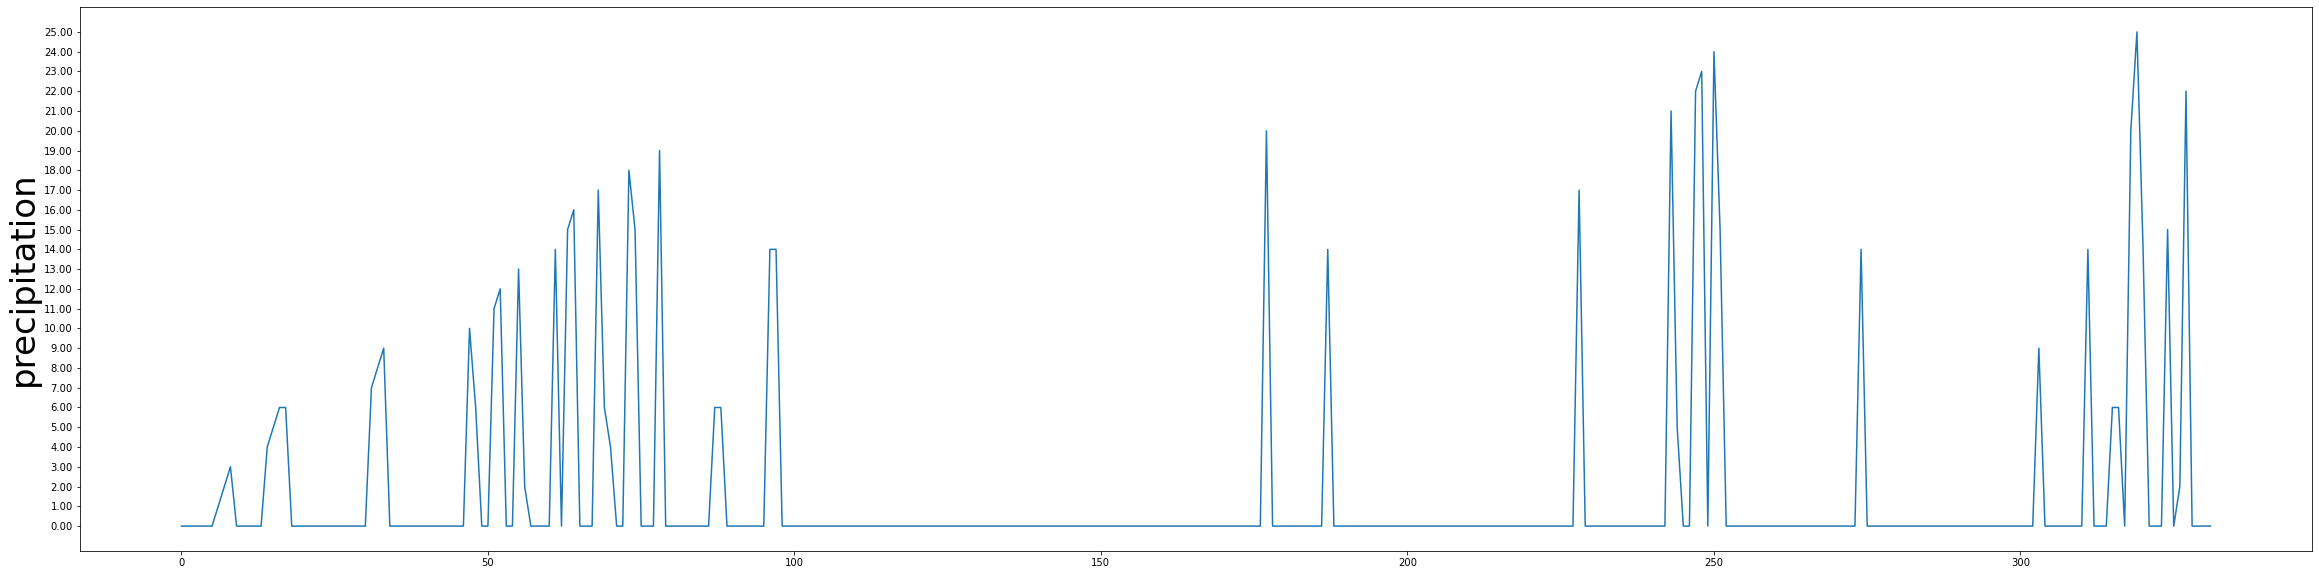

In [8]:
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots(figsize=(40, 10))

ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.ylabel('precipitation',fontsize=34)                                   
plt.plot(all_data['precipitation'])

Text(0.5, 1.0, 'Taux de remplissage en fctn du temps')

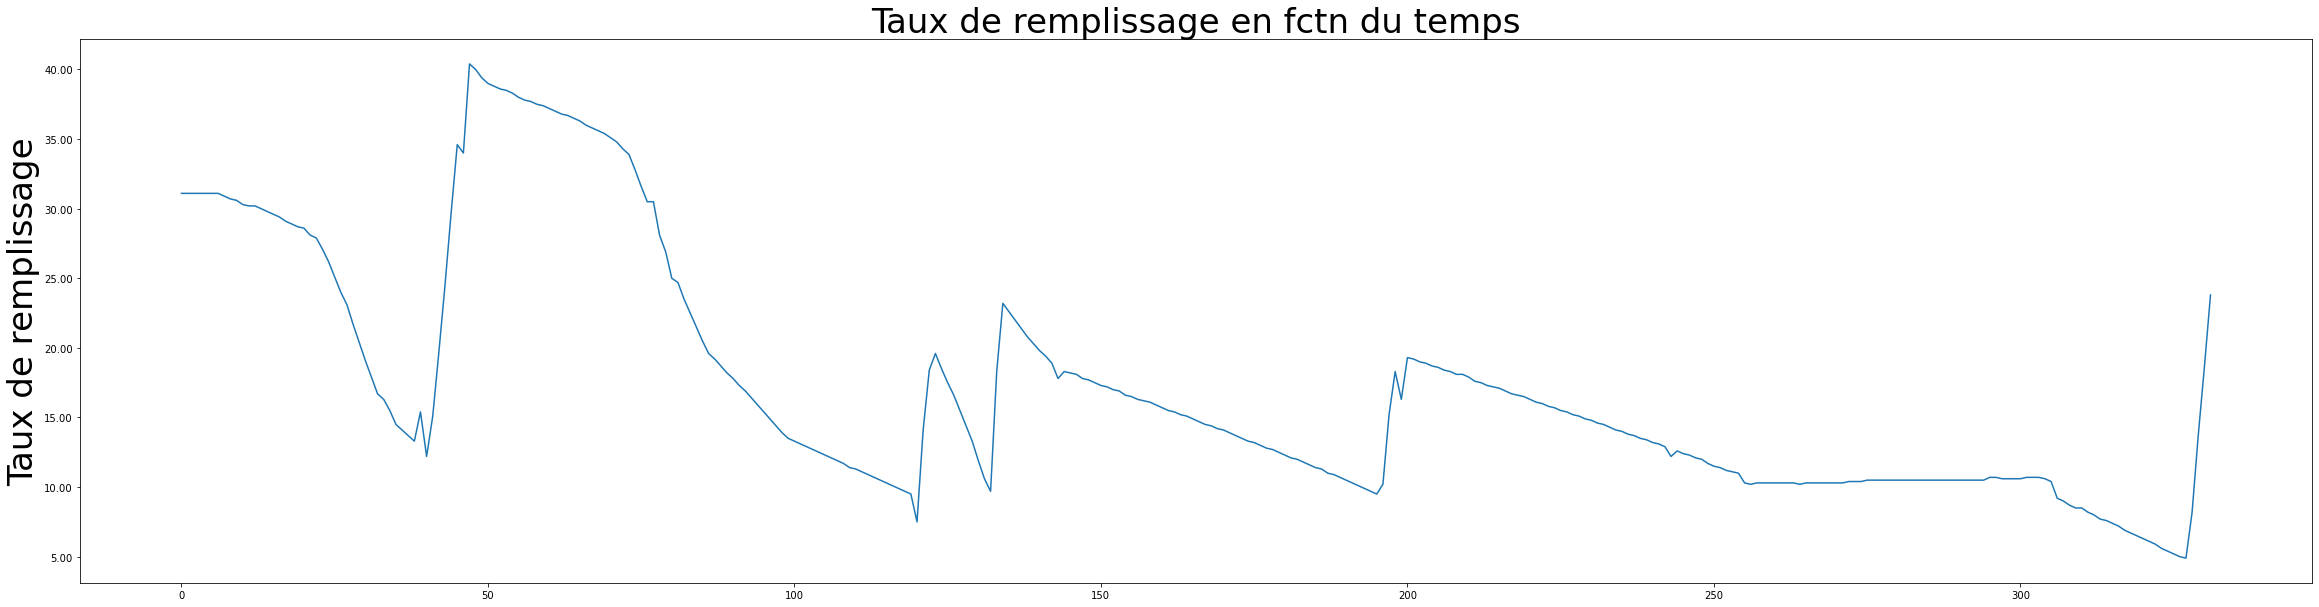

In [9]:
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots(figsize=(40, 10))

ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
                             
plt.ylabel('Taux de remplissage',fontsize=34)                             
plt.plot(all_data['taux_de_remplissage_percent'])
plt.title('Taux de remplissage en fctn du temps',fontsize=34)

✔  On remarque qui'il n y'a pas un pattern qui se repete sur une intervalle donée donc pas de saisonalité

#### **Stationnarité**

* **Par observation**

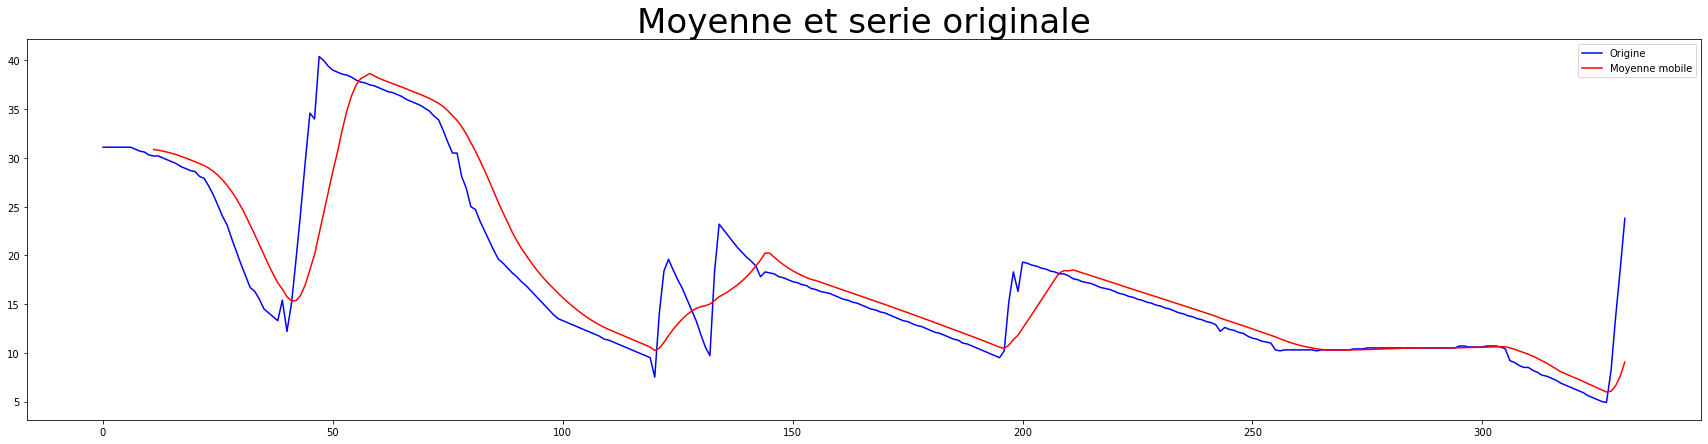

In [10]:
fig, ax = plt.subplots(figsize=(30, 7))
rolling_mean = all_data["taux_de_remplissage_percent"].rolling(window = 12).mean()
plt.plot(all_data["taux_de_remplissage_percent"], color = 'blue', label = 'Origine')
plt.plot(rolling_mean, color = 'red', label = 'Moyenne mobile')
plt.legend(loc = 'best')
plt.title('Moyenne et serie originale',fontsize=34)
plt.show()

✔ On remarque les grandes variations  du  moyen mobile varie  donc on peut estimer que notre série de données n'est pas stationnaire

* **Par test de Dickey Fuller**

In [11]:
result = adfuller(all_data["taux_de_remplissage_percent"])
 
print('Statistiques ADF : {}'.format(result[0]))
print('p-value : {}'.format(result[1]))
print('Valeurs Critiques :')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

Statistiques ADF : -2.423783684369106
p-value : 0.13513584386444583
Valeurs Critiques :
	1%: -3.451148243362826
	5%: -2.8707010565250752
	10%: -2.571650950153748


✔  P-value > 0.05 alors on est sure de la non stationnarité

#### **Solution : Autoregressif Integrated Moving average**

Le modèle qui sera le plus adéquat dans cet situation est le modèle : **ARIMA** qui sert à surmonter le problem de la non stationnarité. <br><br>
Le modèle ARIMA ajoute une différence à un modèle ARMA. La différenciation soustrait la valeur actuelle de la précédente et peut être utilisée pour transformer une série temporelle en une série stationnaire. Par exemple, la différenciation du premier ordre traite des tendances linéaires et utilise la transformation zi = yi – yi-1.
La différenciation du second ordre traite des tendances quadratiques et utilise une différence du premier ordre sur une différence du premier ordre, à savoir zi = (yi – yi-1) – (yi-1 – yi-2), et ainsi de suite.

In [12]:
model = auto_arima(all_data["taux_de_remplissage_percent"],test='adf',seasonal=False)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  332
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -506.338
Date:                Sun, 13 Nov 2022   AIC                           1018.675
Time:                        00:30:50   BIC                           1030.082
Sample:                             0   HQIC                          1023.225
                                - 332                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6537      0.036     18.178      0.000       0.583       0.724
ma.L1         -0.2312      0.045     -5.186      0.000      -0.319      -0.144
sigma2         1.2470      0.028     44.332      0.000       1.192       1.302
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              8838.99
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.30   Skew:                             3.45
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### **Evaluation**

##### Splitting en train et test

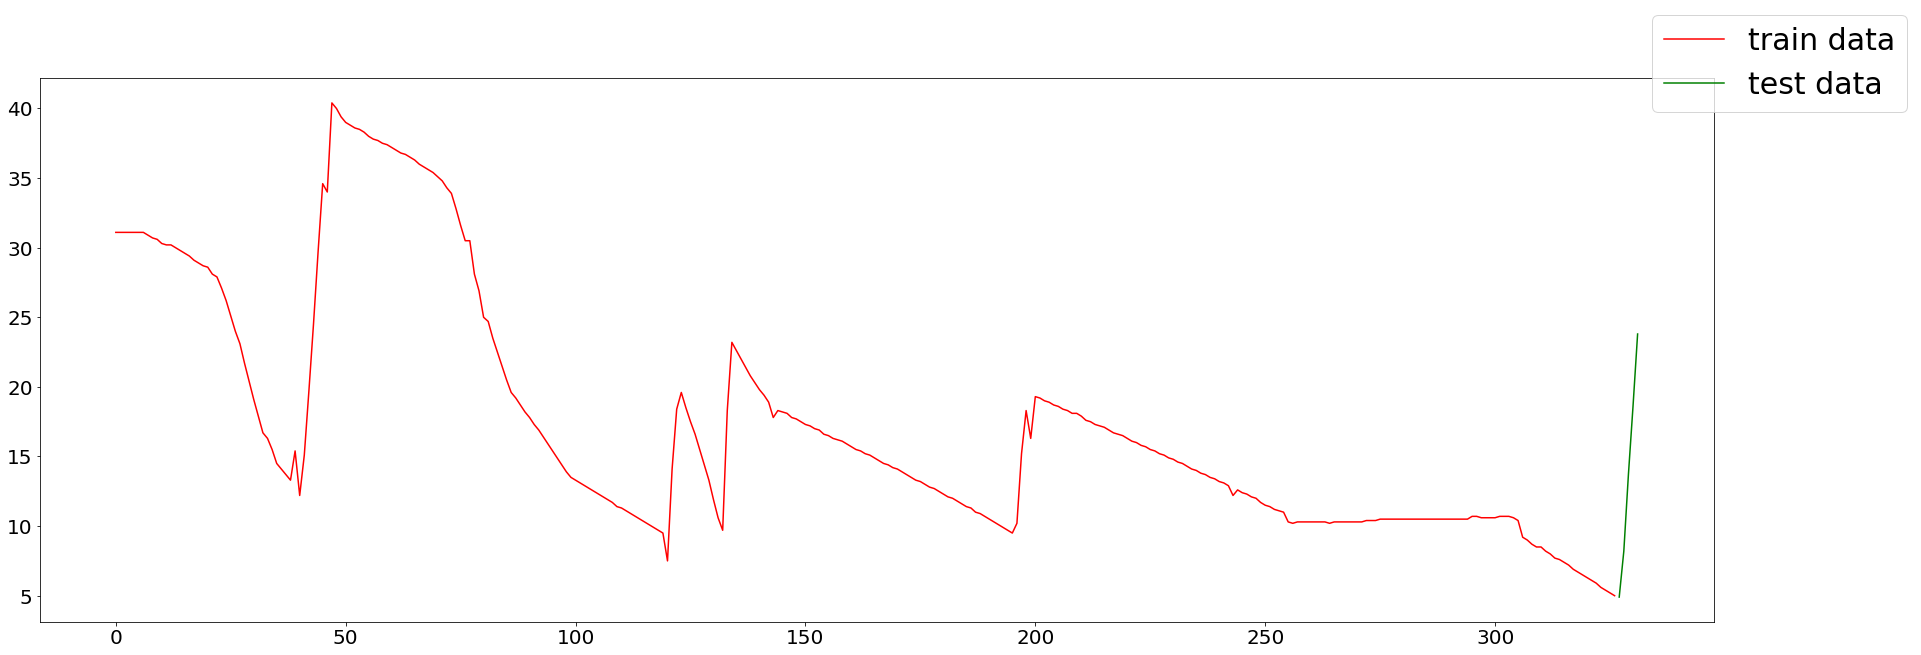

In [21]:
train = all_data["taux_de_remplissage_percent"].iloc[:len(all_data)-5]
valid = all_data["taux_de_remplissage_percent"].iloc[len(all_data)-5:]
fig, ax = plt.subplots(figsize=(30, 10))

#plotting the data
plt.plot(train, color = 'red', label='train data') 
plt.plot(valid, color = 'green', label ='test data')
fig.legend(fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt. show()

In [35]:
# Forecast
n_periods = 5
forecast, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_forecast = np.arange(len(all_data["taux_de_remplissage_percent"]), len(all_data["taux_de_remplissage_percent"])+n_periods)

In [36]:
forecast = forecast.reset_index()
forecast.drop(columns=["index"],inplace = True)

In [50]:
valid = valid.reset_index()
valid.drop(columns=["index"],inplace = True)

In [51]:
for i in range(0,len(forecast)):
    print('Value =', round (forecast.values[i][0],3),'  ;  Expected =', round(valid.values[i][0],3) )

Value = 26.617   ;  Expected = 4.9
Value = 28.458   ;  Expected = 8.2
Value = 29.661   ;  Expected = 13.7
Value = 30.448   ;  Expected = 18.6
Value = 30.962   ;  Expected = 23.8


##### **RMSE**

In [ ]:
# error = rmse(valid['prcp'],forecast)
# print('RMSE Error: ', error)

from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=np.sqrt(mean_squared_error(valid['prcp'],forecast))
print(rmse)

### **Modèle 2 : Vector Autoregression**